In [1]:
# grep -i "gw01.extranet.frachtwerk.de filterlog" pfsense.log > pfsense.csv
import pandas
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
# Full parquet needs to be build
# df = pd.read_parquet('./data/df_v4.parquet', engine='pyarrow') 
df = pandas.read_parquet('./data/df_v4_10000', engine='pyarrow') 

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17,20,21,24,25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
test_df = df.head(1000)
test_df['timestamp'] # date

0      Sep  7 11:45:50 gw01.extranet.frachtwerk.de fi...
1      Sep  7 11:45:52 gw01.extranet.frachtwerk.de fi...
2      Sep  7 11:46:00 gw01.extranet.frachtwerk.de fi...
3      Sep  7 11:46:00 gw01.extranet.frachtwerk.de fi...
4      Sep  7 11:46:12 gw01.extranet.frachtwerk.de fi...
                             ...                        
995    Sep  7 12:16:49 gw01.extranet.frachtwerk.de fi...
996    Sep  7 12:16:50 gw01.extranet.frachtwerk.de fi...
997    Sep  7 12:16:54 gw01.extranet.frachtwerk.de fi...
998    Sep  7 12:16:55 gw01.extranet.frachtwerk.de fi...
999    Sep  7 12:16:57 gw01.extranet.frachtwerk.de fi...
Name: 0, Length: 1000, dtype: object

In [5]:
# Show time statistics
# Logging took place between 09-07 11:45:50 and 12-07 09:22:02 (3 months)
df['timestamp'].describe()

count                15393168
unique                5211151
top       1900-10-11 22:26:55
freq                    25445
first     1900-09-07 11:45:50
last      1900-12-07 09:22:02
Name: date, dtype: object

In [12]:
# Strip seconds to identify firewall logs per minute
df['date_minutes'] = df['timestamp'].dt.strftime('%m-%d %H:%M')
df['date_minutes']

0           09-07 11:45
1           09-07 11:45
2           09-07 11:46
3           09-07 11:46
4           09-07 11:46
               ...     
15393163    12-07 09:21
15393164    12-07 09:21
15393165    12-07 09:21
15393166    12-07 09:22
15393167    12-07 09:22
Name: date_minutes, Length: 15393168, dtype: object

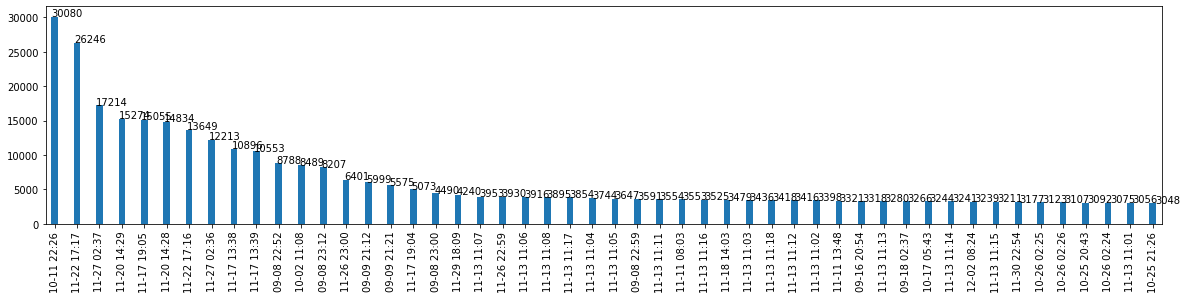

In [18]:
# Detect firewall log anomalies (Logs per minute, top 50)
ax = df['date_minutes'].value_counts()[:50].plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [16]:
df['date_minutes'].value_counts().describe()

count    130593.000000
mean        117.871310
std         256.359653
min           2.000000
25%          53.000000
50%          69.000000
75%          98.000000
max       30080.000000
Name: date_minutes, dtype: float64

# Logs per minute (Freq top 50)
Until the 18th (09-08-23:00) entry from the left we seem to have a higher log count per minute than usual (bar chart).
Looking at the overall mean all the entries seem unusual high as 117 logs per minute are the norm.

### Analysis of top 18
1. 10-11 22:26 - 30.080  = Possible denial of service attack
2. 11-22 17:17 - 26.246  = 2 & 7 Possible denial of service attack
3. 11-27 02:37 - 17.214  = 3 & 8 Possible denial of service attack
4. 11-20 14:29 - 15.274  = 4 & 6 Possible denial of service attack
5. 11-17 19:05 - 15.055  = 5 & 17 Possible denial of service attack
6. 11-20 14:28 - 14.834  = 4 & 6 Possible denial of service attack
7. 11-22 17:16 - 13.649  = 2 & 7 Possible denial of service attack
8. 11-27 02:36 - 12.213  = 3 & 8 Possible denial of service attack
9. 11-17 13:38 - 10.896  = 9 & 10 Possible denial of service attack
10. 11-17 13:39 - 10.553 = 9 & 10 Possible denial of service attack
11. 09-08 22:52 - 8.788  = 18 & 11 & 13 Possible denial of service attack 
12. 10-02 11:08 - 8.489  = Possible denial of service attack
13. 09-08 23:12 - 8.207  = 18 & 11 & 13 Possible denial of service attack 
14. 11-26 23:00 - 6.401  = Possible denial of service attack
15. 09-09 21:12 - 5.999  = 15 & 16 Possible denial of service attack 
16. 09-09 21:21 - 5.575  = 15 & 16 Possible denial of service attack
17. 11-17 19:04 - 5.073  = 5 & 17 Possible denial of service attack
18. 09-08 23:00 - 4.490  = 18 & 11 & 13 Possible denial of service attack 

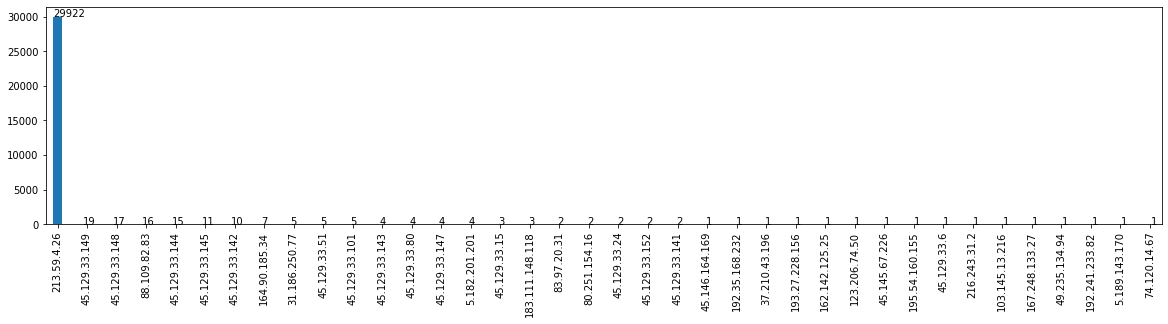

In [23]:
# 1. 10-11 22:26 - 30.080  = Possible denial of service attack
is_date = df['date_minutes'] == '10-11 22:26'
is_date_df = df[is_date]
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 213.59.4.26
Details provided by shodan.io
- Country	Russia
- Organization	Rostelecom
- ISP	Rostelecom
- Last Update	2020-12-25T15:23:02.040649
- ASN	AS8342

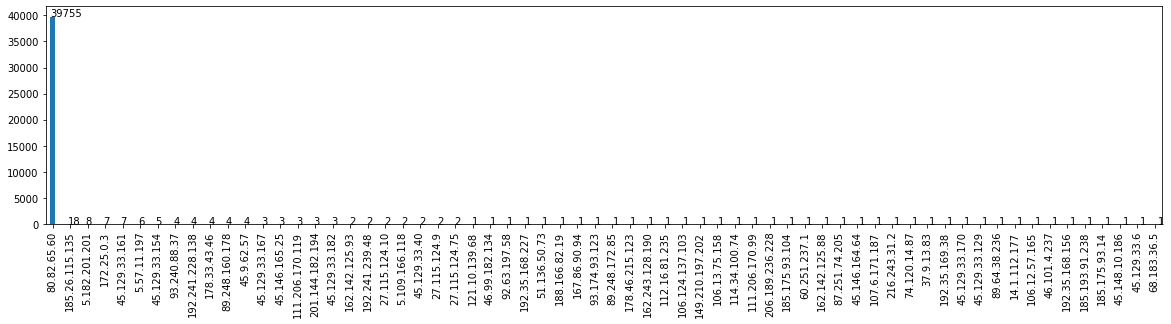

In [37]:
# 2. & 7. 11-22 17:17 & 11-22 17:16 = Possible denial of service attack
is_date = (df['date_minutes'] == '11-22 17:17') | (df['date_minutes'] == '11-22 17:16')
is_date_df = df[is_date]
is_date_df
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 80.82.65.60
Details provided by shodan.io
- Country	United Kingdom
- Organization	IP Volume inc
- ISP	IP Volume inc
- Last Update	2020-12-25T11:28:50.316477
- Hostnames	scanner.openportstats.com
- ASN	AS202425

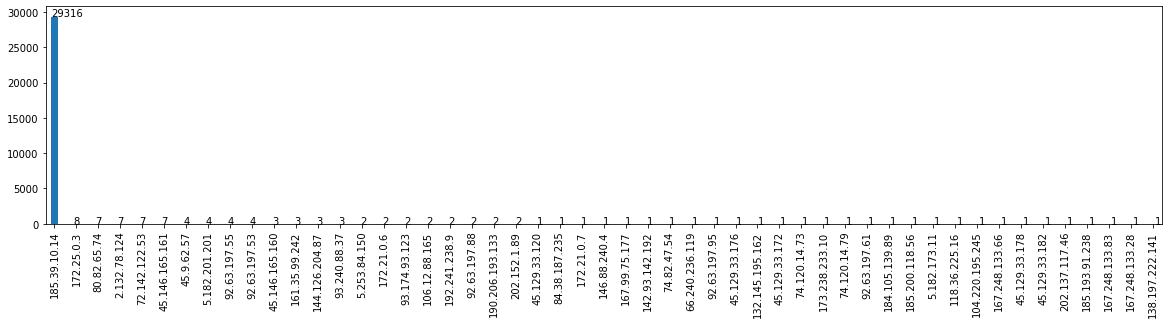

In [39]:
# 3. & 8. 11-27 02:37 & 11-27 02:36 = Possible denial of service attack
is_date = (df['date_minutes'] == '11-27 02:37') | (df['date_minutes'] == '11-27 02:36')
is_date_df = df[is_date]
is_date_df
# list source ips involved in the attack
ax = is_date_df[18].value_counts().plot(kind='bar',figsize=(20,4), width=0.3)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Dangerous IP is 185.39.10.14

Details provided by shodan.io

- Country	Switzerland
- Organization	Network Dedicated SAS
- ISP	Network Dedicated SAS
- Last Update	2020-12-06T02:14:15.169888
- ASN	AS62355